In [32]:
import numpy as np
import pandas as pd
import os, time
import pickle, gzip
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib.colors import NoNorm

from sklearn import preprocessing as pp
from scipy.stats import pearsonr
from numpy.testing import assert_array_almost_equal
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import log_loss, precision_recall_curve, average_precision_score, roc_curve, auc, roc_auc_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import warnings

color = sns.color_palette()
%matplotlib inline
warnings.filterwarnings("ignore")

На этот раз попробуем приблизиться к чтению различных данных. В этот раз картинки из популярного датасета MNIST, который состоит из набора рукописных чисел с их метками. Загрузим датасет и посмотрим на данные:

In [3]:
path_to_dataset = './../data/mnist/'
dataset_name = 'mnist.pkl.gz'

# Открываем архив при помощи контекстного менеджера и читаем пикл файл
f = gzip.open(os.path.join(path_to_dataset, dataset_name), 'rb')
train_set, validation_set, test_set = pickle.load(f, encoding='latin1')
f.close()

# Раскладываем данные по выборкам
X_train, y_train = train_set[0], train_set[1]
X_validation, y_validation = validation_set[0], validation_set[1]
X_test, y_test = test_set[0], test_set[1]

# Смотрим на размеры датасетов
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_validation: ", X_validation.shape)
print("Shape of y_validation: ", y_validation.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (50000, 784)
Shape of y_train:  (50000,)
Shape of X_validation:  (10000, 784)
Shape of y_validation:  (10000,)
Shape of X_test:  (10000, 784)
Shape of y_test:  (10000,)


Посмотрим как выглядят наши данные в Pandas DataFrame (спойлер: это бесполезно)

In [4]:
# Для начала не забываем про индексы:
train_index = range(0,len(X_train))
validation_index = range(len(X_train), len(X_train) + len(X_validation))
test_index = range(len(X_train)+len(X_validation), len(X_train) + len(X_validation)+len(X_test))

# Распределяем данные согласно индексам:
X_train = pd.DataFrame(data=X_train, index=train_index)
y_train = pd.Series(data=y_train, index=train_index)
X_validation = pd.DataFrame(data=X_validation, index=validation_index)
y_validation = pd.Series(data=y_validation ,index=validation_index)
X_test = pd.DataFrame(data=X_test, index=test_index)
y_test = pd.Series(data=y_test, index=test_index)

Посмотрим на статистики по данным, практические везде 0, как вы думаете почему?

In [5]:
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
count,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.0,50000.0,50000.0,50000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000739,0.000354,0.000204,0.000090,0.000071,0.000009,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.022784,0.015424,0.012080,0.007218,0.007181,0.001483,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.992188,0.992188,0.988281,0.988281,0.992188,0.242188,0.0,0.0,0.0,0.0


In [6]:
# Посмотрим как устроены метки
y_train.head()

0    5
1    0
2    4
3    1
4    9
dtype: int64

In [7]:
# Попробуем визализировать данные, прежде чем построить визуализацию помним что в датасете картинки 28х28 пикселей, что представляет с собой вектор с 784 элементами:
# https://matplotlib.org/stable/tutorials/introductory/images.html прочитайте документацию
def view_digit(row_number):
    label = y_train.loc[row_number]
    image = X_train.loc[row_number,:].values.reshape([28,28])
    plt.title('Example: %d Label: %d' % (row_number, label))
    plt.imshow(image, cmap = mpl.cm.gray)
    plt.show();
    return None

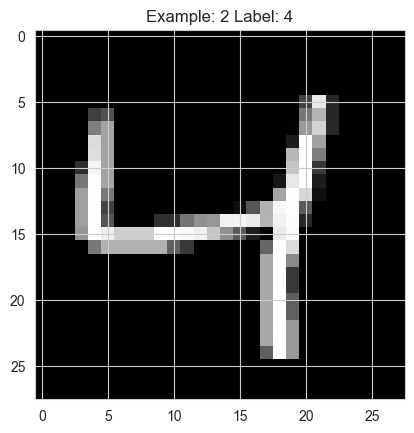

In [8]:
view_digit(row_number=2)

# PCA

Мы установим количество основных компонент равным исходному количеству измерений (т.е. 784).
Затем PCA захватит важную информацию из исходных измерений и начнет генерировать главные компоненты.
Как только эти компоненты будут сгенерированы, мы определим, сколько основных компонентов нам нужно, чтобы эффективно получить большую часть дисперсии/информации из исходного признакового пространства.

In [10]:
from sklearn.decomposition import PCA

n_components = 784
whiten = False # аргумент используется для поправки на вывод данных с единичной покомпонентной дисперсией
random_state = 42

pca = PCA(n_components=n_components, whiten=whiten, random_state=random_state)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=train_index)

Проведем оценку полченной трансформации:

In [11]:
# % дисперсии при 784 компонентах
print(f"Variance Explained by all 784 principal components: { round(sum(pca.explained_variance_ratio_), 2)}")

Variance Explained by all 784 principal components: 1.0


Посмотрим кумулятивное распределение главных компонент и их "схваченную" объясненную дисперсию в датасете:

In [12]:
importanceOfPrincipalComponents = pd.DataFrame(data=pca.explained_variance_ratio_)
importanceOfPrincipalComponents = importanceOfPrincipalComponents.T

print('Variance Captured by First 10 Principal Components: ',  importanceOfPrincipalComponents.loc[:,0:9].sum(axis=1).values)
print('Variance Captured by First 20 Principal Components: ',  importanceOfPrincipalComponents.loc[:,0:19].sum(axis=1).values)
print('Variance Captured by First 50 Principal Components: ',  importanceOfPrincipalComponents.loc[:,0:49].sum(axis=1).values)
print('Variance Captured by First 100 Principal Components: ', importanceOfPrincipalComponents.loc[:,0:99].sum(axis=1).values)
print('Variance Captured by First 200 Principal Components: ', importanceOfPrincipalComponents.loc[:,0:199].sum(axis=1).values)
print('Variance Captured by First 300 Principal Components: ', importanceOfPrincipalComponents.loc[:,0:299].sum(axis=1).values)

Variance Captured by First 10 Principal Components:  [0.48876235]
Variance Captured by First 20 Principal Components:  [0.6439802]
Variance Captured by First 50 Principal Components:  [0.8248609]
Variance Captured by First 100 Principal Components:  [0.9146585]
Variance Captured by First 200 Principal Components:  [0.9665007]
Variance Captured by First 300 Principal Components:  [0.9862489]


Как мы увидели, первые 10 компонент в целом охватывают 50% объясненной дисперсии, первые 100 - 90% далее уже находится менее важная информация, которая теоретически не так полезна.
Теперь всё более или менее очевидно.
Только с первыми двумя сотнями главных компонент (гораздо меньше, чем исходные 784 измерения) мы охватываем более 96% дисперсии/информации. Этого достаточно чтобы выявить какие-либо паттерны в наборе данных!

PCA позволяет нам существенно уменьшить размерность исходных данных, сохраняя при этом большую часть существенной информации.

<Axes: >

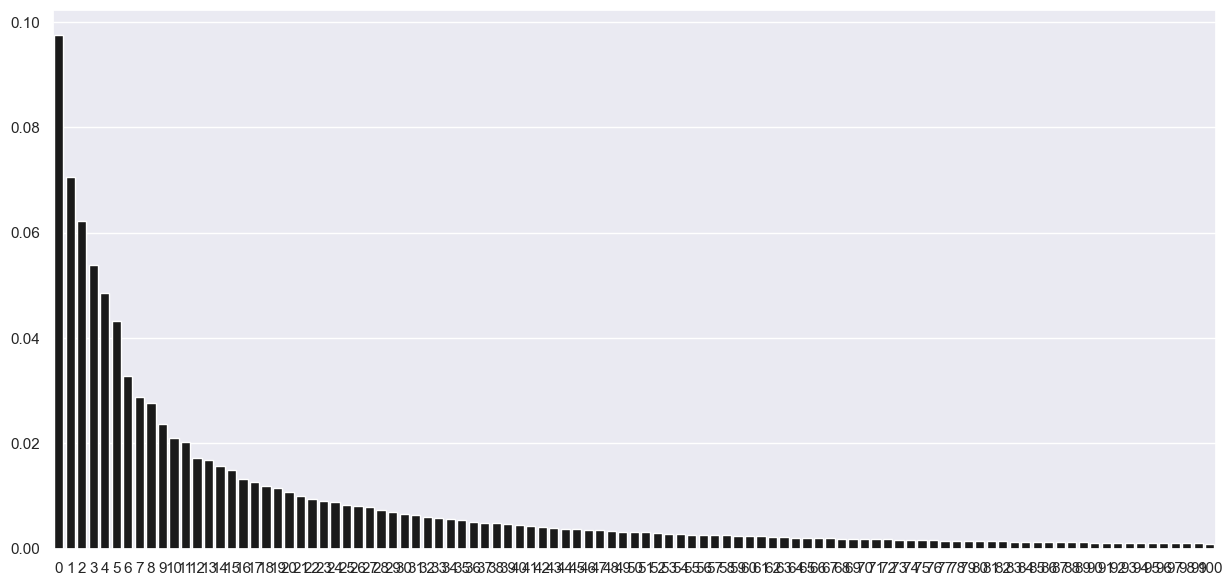

In [13]:
# View percentage captured by first X components
sns.set(rc={'figure.figsize':(15,7)})
sns.barplot(data=importanceOfPrincipalComponents.loc[:,0:100],color='k')

In [19]:
# Define scatterplot function
def scatterPlot(xDF, yDF, algoName):
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    tempDF.columns = ["PCA1", "PCA2", "Label"]
    plt.figure(figsize=(20, 10))
    sns.lmplot(x="PCA1", y="PCA2", hue="Label", data=tempDF, fit_reg=False)
    ax = plt.gca()
    ax.set_title("Separation of Observations using "+algoName)

<Figure size 2000x1000 with 0 Axes>

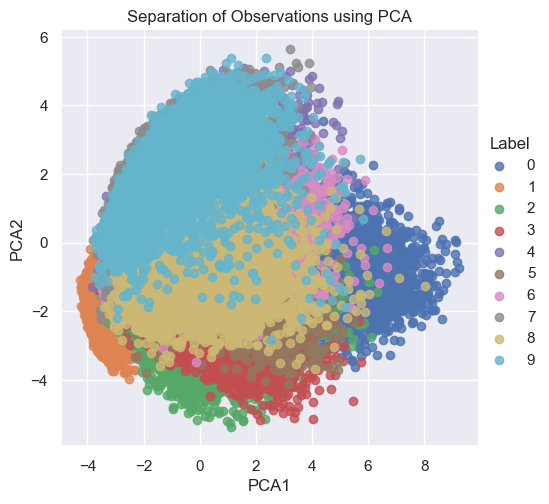

In [20]:
# View scatterplot
scatterPlot(X_train_PCA, y_train, "PCA")

Как видно на графике, только благодаря 2-ум главным компонентам нам получилось визуализировать данные и увидеть некую зависимость. Появились кластеры данных, где похожие точки очень близки к друг другу. Таким образом без каких-либо меток данных мы смогли понизить размерность данных и увидеть определенную зависимость и сформировать кластеры данных. Посмотрим на вариации различных подходов к PCA:

# Incremental PCA

Уменьшение линейной размерности с использованием разложения данных по сингулярным значениям с сохранением только наиболее значимых сингулярных векторов для проецирования данных в пространство более низкой размерности. Входные данные центрируются, но не масштабируются для каждой функции перед применением SVD.

В зависимости от размера входных данных этот алгоритм может быть намного более эффективным с точки зрения использования памяти, чем PCA, и допускает разреженный ввод.

<Figure size 2000x1000 with 0 Axes>

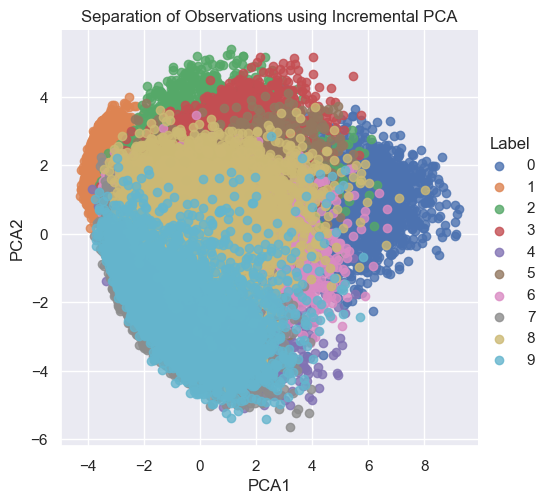

In [21]:
from sklearn.decomposition import IncrementalPCA

n_components = 784
batch_size = 1024

incrementalPCA = IncrementalPCA(n_components=n_components, batch_size=batch_size)

X_train_incrementalPCA = incrementalPCA.fit_transform(X_train)
X_train_incrementalPCA = pd.DataFrame(data=X_train_incrementalPCA, index=train_index)

X_validation_incrementalPCA = incrementalPCA.transform(X_validation)
X_validation_incrementalPCA =  pd.DataFrame(data=X_validation_incrementalPCA, index=validation_index)

scatterPlot(X_train_incrementalPCA, y_train, "Incremental PCA")

# Sparse PCA

Находит набор разреженных компонентов, которые могут оптимально восстановить данные. Величина разреженности регулируется коэффициентом штрафа L1, заданным параметром альфа.

<Figure size 2000x1000 with 0 Axes>

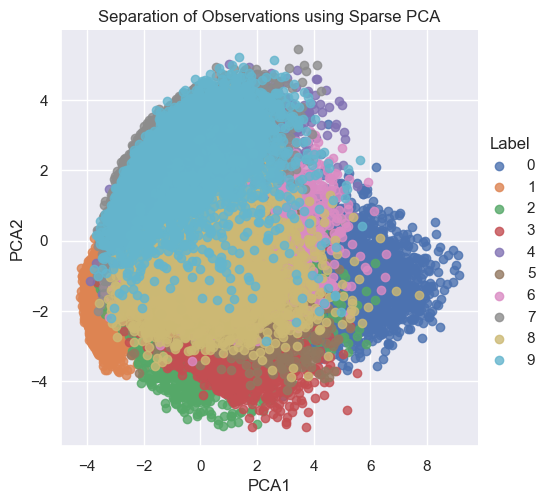

In [22]:
from sklearn.decomposition import SparsePCA

n_components = 100
alpha = 0.0001
random_state = 42
n_jobs = -1

sparsePCA = SparsePCA(n_components=n_components, alpha=alpha, random_state=random_state, n_jobs=n_jobs)
sparsePCA.fit(X_train.loc[:10000,:])

X_train_sparsePCA = sparsePCA.transform(X_train)
X_train_sparsePCA = pd.DataFrame(data=X_train_sparsePCA, index=train_index)

X_validation_sparsePCA = sparsePCA.transform(X_validation)
X_validation_sparsePCA = pd.DataFrame(data=X_validation_sparsePCA, index=validation_index)
scatterPlot(X_train_sparsePCA, y_train, "Sparse PCA")

# Kernel PCA

<Figure size 2000x1000 with 0 Axes>

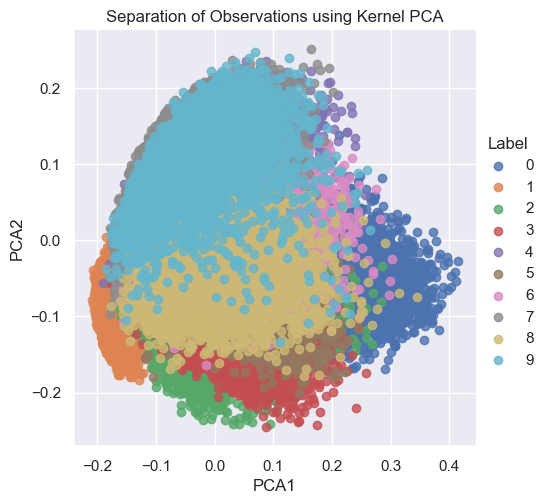

In [23]:
from sklearn.decomposition import KernelPCA

n_components = 100
kernel = 'rbf'
gamma = None
random_state = 42
n_jobs = 1

kernelPCA = KernelPCA(n_components=n_components, kernel=kernel, gamma=gamma, n_jobs=n_jobs, random_state=random_state)
kernelPCA.fit(X_train.loc[:10000,:])

X_train_kernelPCA = kernelPCA.transform(X_train)
X_train_kernelPCA = pd.DataFrame(data=X_train_kernelPCA,index=train_index)

X_validation_kernelPCA = kernelPCA.transform(X_validation)
X_validation_kernelPCA = pd.DataFrame(data=X_validation_kernelPCA, index=validation_index)

scatterPlot(X_train_kernelPCA, y_train, "Kernel PCA")

Иногда главные компоненты можно интерпретировать:

In [24]:
df_wine = pd.read_csv('./../data/wine.data', header=None)

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [25]:
from matplotlib.colors import ListedColormap
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.01):
    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=f'Class {cl}',
                    edgecolor='black')

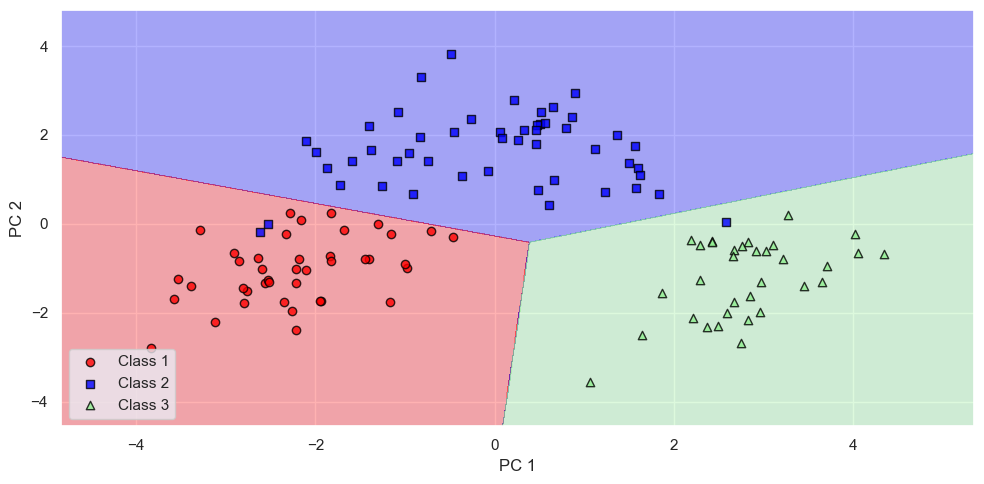

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
# initializing the PCA transformer and
# logistic regression estimator:
pca = PCA(n_components=2)
lr = LogisticRegression(multi_class='ovr',
                        random_state=42,
                        solver='lbfgs')
# dimensionality reduction:
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

# fitting the logistic regression model on the reduced dataset:
lr.fit(X_train_pca, y_train)
plt.figure(figsize=(10, 5))
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

In [27]:
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.35730453, 0.19209164, 0.11006755, 0.07250719, 0.06973166,
       0.05341402, 0.04555029, 0.0241568 , 0.02040417, 0.01976974,
       0.01685307, 0.01086639, 0.00728295])

Мы можем оценить вклад исходных признаков в главные компоненты.
При помощью PCA мы создаем основные компоненты, которые представляют собой линейные комбинации признаков.
Иногда интересно узнать, какой вклад вносит каждый признак в данный главный компонент.
Эти вклады часто называют нагрузками (Loadings).

In [28]:
pca.components_

array([[-0.15763477,  0.25237011,  0.01662626,  0.23514225, -0.14285062,
        -0.38989121, -0.42596901,  0.28675917, -0.30864294,  0.08886736,
        -0.30119689, -0.37783572, -0.28836287],
       [-0.49414675, -0.1670862 , -0.33581955,  0.0230456 , -0.2816766 ,
        -0.07164769, -0.00569565, -0.04855187, -0.00589032, -0.52633004,
         0.28399523,  0.18136641, -0.3703045 ],
       [ 0.13550025, -0.08484512, -0.61436922, -0.62199483, -0.08744449,
        -0.18025489, -0.1288233 , -0.22290079, -0.16925303,  0.15886766,
        -0.14029634, -0.13133987,  0.11347494],
       [-0.22002101,  0.34863385, -0.21029079,  0.11850515,  0.54616385,
        -0.01134185, -0.01728643, -0.43279572,  0.38816555, -0.05280192,
        -0.29582335, -0.05170014, -0.20518301],
       [ 0.1001375 ,  0.51191077, -0.10967198, -0.01880619, -0.60714326,
         0.28882326,  0.23108185,  0.03104048,  0.17123031,  0.08025659,
        -0.32935599,  0.21901727, -0.13011228],
       [-0.20436914, -0.364529

In [29]:
sklearn_loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

<Figure size 1000x500 with 0 Axes>

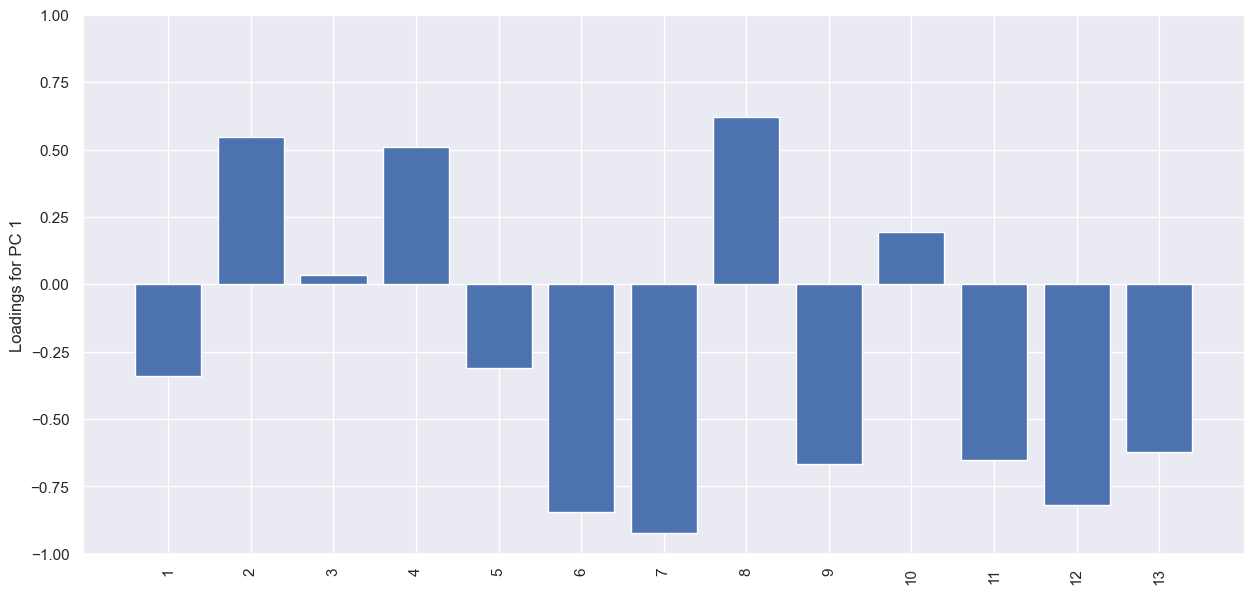

In [30]:
plt.figure(figsize=(10, 5))
fig, ax = plt.subplots()
ax.bar(range(13), sklearn_loadings[:, 0], align='center')
ax.set_ylabel('Loadings for PC 1')
ax.set_xticks(range(13))
ax.set_xticklabels(df_wine.columns[1:], rotation=90)
plt.ylim([-1, 1])
plt.show()

# SVD

<Figure size 2000x1000 with 0 Axes>

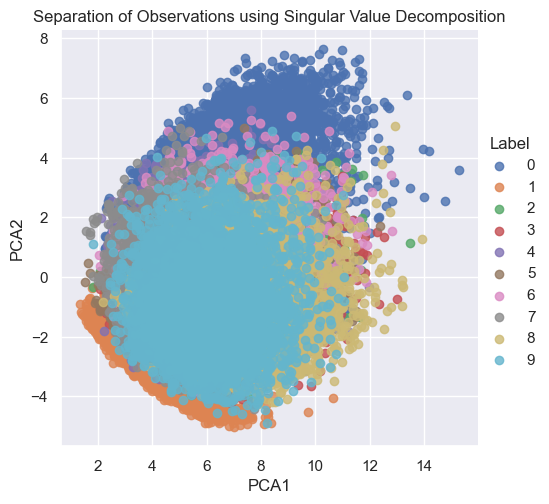

In [31]:
from sklearn.decomposition import TruncatedSVD

# Открываем архив при помощи контекстного менеджера и читаем пикл файл
f = gzip.open(os.path.join(path_to_dataset, dataset_name), 'rb')
train_set, validation_set, test_set = pickle.load(f, encoding='latin1')
f.close()

# Раскладываем данные по выборкам
X_train, y_train = train_set[0], train_set[1]
X_validation, y_validation = validation_set[0], validation_set[1]
X_test, y_test = test_set[0], test_set[1]

# Для начала не забываем про индексы:
train_index = range(0,len(X_train))
validation_index = range(len(X_train), len(X_train) + len(X_validation))
test_index = range(len(X_train)+len(X_validation), len(X_train) + len(X_validation)+len(X_test))

# Распределяем данные согласно индексам:
X_train = pd.DataFrame(data=X_train, index=train_index)
y_train = pd.Series(data=y_train, index=train_index)
X_validation = pd.DataFrame(data=X_validation, index=validation_index)
y_validation = pd.Series(data=y_validation ,index=validation_index)
X_test = pd.DataFrame(data=X_test, index=test_index)
y_test = pd.Series(data=y_test, index=test_index)

n_components = 5
algorithm = 'randomized'
n_iter = 5
random_state = 42

svd = TruncatedSVD(n_components=n_components, algorithm=algorithm, n_iter=n_iter, random_state=random_state)

X_train_svd = svd.fit_transform(X_train)
X_train_svd = pd.DataFrame(data=X_train_svd, index=train_index)

X_validation_svd = svd.transform(X_validation)
X_validation_svd = pd.DataFrame(data=X_validation_svd, index=validation_index)

scatterPlot(X_train_svd, y_train, "Singular Value Decomposition")